# How to add surface values to GemPy v3 models
This short howto demontrates adding surface values such as seismic velocities, density, porosity to surface layers in GemPy v3. This functionality was directly available in previous versions of GemPy.
This howto came about implementing an excellent tutorial created by Ed Caunt for transform 2021 - [Creating seismic synthetics with Devito and GemPy](https://github.com/devitocodes/transform2021/blob/main/creating_synthetics.ipynb).
All background and setup information can be found there and all credit to Ed Caunt.

Frans B Slabber frans@gaiamathematica.net Sept 2024
Note- This was done in Visual Code on linux.

In [18]:
# Uncomment for first time install.
# !pip install numpy
# !pip install pandas
# !pip install gempy
# !pip install gempy_viewer
# !pip install jinja2
# !pip install pyvista


import gempy as gp
import gempy

# Importing auxiliary libraries
import numpy as np
import pandas as pd
import gempy_viewer as gpv

%matplotlib inline
import jinja2


In [19]:
# Set overarching model parameters
extent = (-5., 1005., -5., 1005., -1005., 5.)
shape = (101, 101, 101)

geo_model = gp.create_geomodel(project_name='SeisSynth',extent=extent,resolution=shape,
        importer_helper=gp.data.ImporterHelper(
        path_to_orientations="data/orientations.csv",
        path_to_surface_points="data/surfaces.csv"
    )
)
gp.map_stack_to_surfaces( geo_model,
    mapping_object={'Upper': ('water', 'sediments', 'uppershale'),
                    'Lower': ('co2', 'sands')}  )

# Remove the default group
gp.remove_structural_group_by_name(geo_model,'default_formation')
    
sol = gp.compute_model(geo_model)

Setting Backend To: AvailableBackends.numpy
Chunking done: 40 chunks
Chunking done: 36 chunks


In [20]:
# You can comment this out if you don't want execution to pause the display.
gpv.plot_3d(geo_model, show_data=False, image=False, plotter_type='basic')

Add the p-wave velocities associated with each of these layers by substituting the velocity values for the surface id in the lith block array. A bit of trickery here: The lith block contains 7 IDs. So I added 1 in for the "extra" velocity. Still trying to find out where that came from. GemPy filler when surface fir breaks down?

In [21]:
# gempy V3 does not have adding surface values functionality
# hack is to make a float array of same dimen as the lithblock, and replace all surface IDs replaced by P velocities
Vp_array = np.zeros(shape=geo_model.solutions.raw_arrays.lith_block.shape)
print(Vp_array.shape)
Vp_lith_values = [1.5, 1.75, 2.5, 1.1, 2., 2.5, 1]

print(geo_model.solutions.raw_arrays.lith_block.min(), geo_model.solutions.raw_arrays.lith_block.max())

for idx,i in enumerate(geo_model.solutions.raw_arrays.lith_block):
    Vp_array[idx]= Vp_lith_values[i-1]
    
print(Vp_array)


(1030301,)
1 7
[2.5 2.5 2.5 ... 1.5 1.5 1.5]


Reshape the modified lith block array to correct 3D shape for Devito.

In [22]:
# Reshaping our data to the shape required by Devito
reshaped = np.reshape(Vp_array, shape, order='C')
reshaped.shape

(101, 101, 101)

Plot a slice as per original tutorial for comparison.

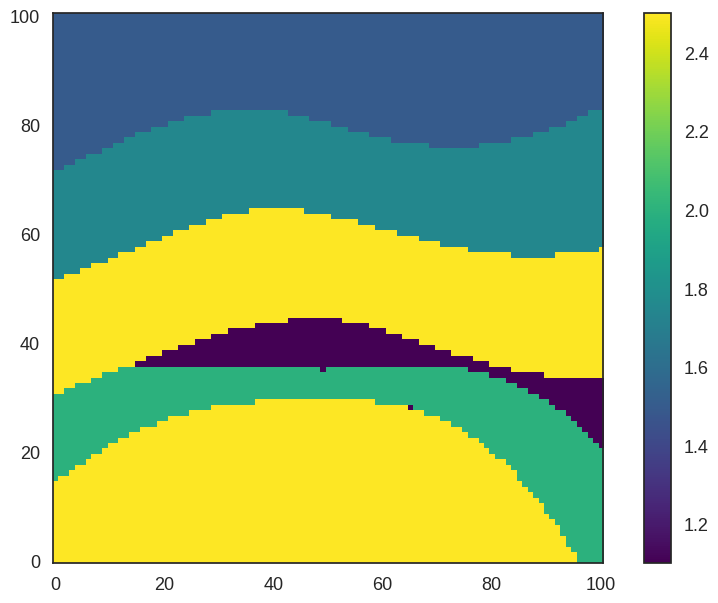

In [23]:
import matplotlib.pyplot as plt

# Take the center slice in the x direction
# Remember that in Devito, indexing convention is [x, y, z] (need to flip for correct imshow display)
plt.imshow(reshaped[50].T, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()